# Кейс №2 - Приложение доставки

Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.



**Данные:**<br>
***ab_users_data*** – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
***ab_orders*** – подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ
***ab_products*** – подробная информация о продуктах, их название и стоимость

In [359]:
import pandas as pd
import numpy as np
import pingouin as pg
import scipy.stats as ss
from  scipy.stats import mannwhitneyu

import seaborn as sns
import matplotlib.pyplot as plt

In [360]:
sns.set(
        style = 'whitegrid',
        font_scale = 1,
        rc = {'figure.figsize': (12, 7)}
       )

In [361]:
users = pd.read_csv('ab_users_data.csv')

In [362]:
orders = pd.read_csv('ab_orders.csv')

In [363]:
products = pd.read_csv('ab_products.csv')

In [6]:
users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   4337 non-null   int64 
 1   order_id  4337 non-null   int64 
 2   action    4337 non-null   object
 3   time      4337 non-null   object
 4   date      4337 non-null   object
 5   group     4337 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 203.4+ KB


В таблице пользователей 4337 строк; пропущенных значений нет; колонки, содержащие данные с датой, приведем к соответствующему типу. 

In [364]:
# Приводим колонку time к типу datetime.
users.time = pd.to_datetime(users.time)

In [365]:
# Приводим колонку date к типу datetime.
users.date = pd.to_datetime(users.date)

In [11]:
orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [12]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4123 entries, 0 to 4122
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   order_id       4123 non-null   int64 
 1   creation_time  4123 non-null   object
 2   product_ids    4123 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.8+ KB


В таблице заказов 4123 строк; пропущенных значений нет; колонку, содержащую данные с датой, приведем к соответствующему типу. ID продуктов содержатся одной строкой в ячейке.

In [366]:
# Приводим колонку creation_time к типу datetime.
orders.creation_time = pd.to_datetime(orders.creation_time)

In [14]:
products.head(3)

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4


In [15]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  87 non-null     int64  
 1   name        87 non-null     object 
 2   price       87 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


В таблице продуктов 87 строк; пропущенных значений; типы данных корректны.

Объединим все три таблицы в одну, чтобы получить единый источник информации. В таблице заказов id продуктов перечислены строкой в одной ячейке. Распарсим данные.

In [367]:
# Каждое значение в колонке product_ids преобразуем сначала из str в set.
orders.product_ids = orders.product_ids.apply(lambda x: eval(x))

In [368]:
# Развернем данные по-элементно в колоке product_ids и переименуем колонку. 
orders = orders.explode('product_ids').rename(columns = {'product_ids': 'product_id'})

In [369]:
# Соединяем все три таблицы по типу внутреннего соединения, по ключу order_id.
orders_total = orders.merge(products, on = 'product_id').merge(users, on = 'order_id').drop(columns = 'time')

In [331]:
orders_total.head(15)

,order_id,creation_time,product_id,name,price,user_id,action,date,group
0,1255,2022-08-26 00:00:19,75,сок ананасовый,120.0,964,create_order,2022-08-26,0
1,1255,2022-08-26 00:00:19,84,мандарины,90.4,964,create_order,2022-08-26,0
2,1255,2022-08-26 00:00:19,53,мука,78.3,964,create_order,2022-08-26,0
3,1255,2022-08-26 00:00:19,22,сок мультифрукт,120.0,964,create_order,2022-08-26,0
4,1287,2022-08-26 00:31:36,75,сок ананасовый,120.0,987,create_order,2022-08-26,0
5,1287,2022-08-26 00:31:36,83,вафли,55.0,987,create_order,2022-08-26,0
6,1403,2022-08-26 03:01:40,75,сок ананасовый,120.0,1073,create_order,2022-08-26,1
7,1403,2022-08-26 03:01:40,67,соль,30.0,1073,create_order,2022-08-26,1
8,1403,2022-08-26 03:01:40,30,энергетический напиток,140.0,1073,create_order,2022-08-26,1
9,1403,2022-08-26 03:01:40,83,вафли,55.0,1073,create_order,2022-08-26,1


In [20]:
orders_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14277 entries, 0 to 14276
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       14277 non-null  int64         
 1   creation_time  14277 non-null  datetime64[ns]
 2   product_id     14277 non-null  object        
 3   name           14277 non-null  object        
 4   price          14277 non-null  float64       
 5   user_id        14277 non-null  int64         
 6   action         14277 non-null  object        
 7   date           14277 non-null  datetime64[ns]
 8   group          14277 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(3), object(3)
memory usage: 1.1+ MB


In [332]:
# Проверим дубликаты в объединенной таблице
orders_total.duplicated().sum()

0

В обобщенной таблице пропусков нет; типы данных корректны; дубликаты отсутствуют.

Согласно условию задачи есть заказы, которые были отменены.

In [371]:
# Проверим статус заказов.
orders_total.action.unique()

array(['create_order'], dtype=object)

In [372]:
# Чтобы оценить эффективность системы рекомендаций, нам понадобятся только успешные(доставленные) заказы.
# Удалим строки, содержащие отмененные заказы.
orders_total = orders_total.query('action == "create_order"')

In [373]:
# Преобразуем таблицу с данными к удобному виду: определим иной порядок столбцов и присвоим имена группам.
orders_total = orders_total[['group', 'user_id', 'order_id', 'action', 'product_id', 'name', 'price', 'date']]
orders_total['group'] = orders_total['group'].apply(lambda x: 'control' if x == 0 else 'experimental')
orders_total.head()

,group,user_id,order_id,action,product_id,name,price,date
0,control,964,1255,create_order,75,сок ананасовый,120.0,2022-08-26
1,control,964,1255,create_order,84,мандарины,90.4,2022-08-26
2,control,964,1255,create_order,53,мука,78.3,2022-08-26
3,control,964,1255,create_order,22,сок мультифрукт,120.0,2022-08-26
4,control,987,1287,create_order,75,сок ананасовый,120.0,2022-08-26


За метрики качества сервиса примем средний чек (AOV), среднюю выручку на одного платящего пользователя (ARPPU), среднее число заказов на одного пользователя и средний объем продуктовой корзины, измеряемый в количестве единиц продукта относительно одного заказа.  <br>
* AOV = Общая выручка за период / Количество заказов за тот же период;
* ARPPU = Общая выручка за период / Количество пользователей за тот же период;
* Среднее число заказов на одного пользователя = Общее число заказов за период / Количество пользователей за тот же период;
* Средний объем продуктовой корзины = Общее число наименований продуктов  за период / Количество заказов за тот же период.

In [385]:
# Сформируем предварительную таблицу для исчисления метрик качества.
# Сначала сгруппируем данные по группе, пользователю и заказу. Найдем выручку  и общее число позиций в заказе
# для каждого пользователя.
# На втором этапе сгруппируем данные только по группам и вычислим общее число пользователей в каждой группе,
# число уникальных заказов, общую сумму выручки и средний размер продуктовой корзины.
metrics = orders_total \
                 .groupby(['group', 'user_id', 'order_id'], as_index = False) \
                 .agg(revenue_with_user_order     = pd.NamedAgg(column = 'price', aggfunc = 'sum'), \
                      product_cnt_with_user_order = pd.NamedAgg(column = 'product_id', aggfunc = 'count')) \
                 .groupby('group', as_index = False) \
                 .agg(user_cnt     = pd.NamedAgg(column = 'user_id', aggfunc = 'nunique'), \
                      order_cnt    = pd.NamedAgg(column = 'order_id', aggfunc = 'count'), \
                      revenue      = pd.NamedAgg(column = 'revenue_with_user_order', aggfunc = 'sum'), \
                      product_mean = pd.NamedAgg(column = 'product_cnt_with_user_order', aggfunc = 'mean'))
                      

metrics

,group,user_cnt,order_cnt,revenue,product_mean
0,control,515,1609,602491.7,3.284027
1,experimental,502,2514,910009.3,3.287987


In [375]:
# Получим интересующие метрики качества сервиса и удалим вспомогательные колонки.
metrics = metrics.assign(arppu = metrics.revenue / metrics.user_cnt,
                 aov = metrics.revenue / metrics.order_cnt,
                 order_per_user = metrics.order_cnt / metrics.user_cnt)
metrics.drop(columns = ['order_cnt', 'revenue'], inplace = True)
metrics

,group,user_cnt,product_mean,arppu,aov,order_per_user
0,control,515,3.284027,1169.886796,374.451025,3.124272
1,experimental,502,3.287987,1812.767530,361.976651,5.007968


In [376]:
# Сформируем относительные показатели метрик качества.
delta_dict = {'user_cnt': "{:+.2%}".format(((metrics.query('group == "experimental"').user_cnt.values - metrics.query('group == "control"').user_cnt.values) \
                          / max(metrics.query('group == "experimental"').user_cnt.values, metrics.query('group == "control"').user_cnt.values))[0]),
              'product_mean': "{:+.2%}".format(((metrics.query('group == "experimental"').product_mean.values - metrics.query('group == "control"').product_mean.values) \
                          / max(metrics.query('group == "experimental"').product_mean.values, metrics.query('group == "control"').product_mean.values))[0]),
              'arppu': "{:+.2%}".format(((metrics.query('group == "experimental"').arppu.values - metrics.query('group == "control"').arppu.values) \
                          / max(metrics.query('group == "experimental"').arppu.values, metrics.query('group == "control"').arppu.values))[0]),
              'aov': "{:+.2%}".format(((metrics.query('group == "experimental"').aov.values - metrics.query('group == "control"').aov.values) \
                          / max(metrics.query('group == "experimental"').aov.values, metrics.query('group == "control"').aov.values))[0]),
              'order_per_user': "{:+.2%}".format(((metrics.query('group == "experimental"').order_per_user.values - metrics.query('group == "control"').order_per_user.values) \
                          / max(metrics.query('group == "experimental"').order_per_user.values, metrics.query('group == "control"').order_per_user.values))[0])}
delta_metrics = pd.DataFrame(delta_dict, index = ['delta'])

In [377]:
delta_metrics

,user_cnt,product_mean,arppu,aov,order_per_user
delta,-2.52%,+0.12%,+35.46%,-3.33%,+37.61%


Число пользователей по группам отличается незначительно, всего лишь на 2,5%. Таким отклонением можно пренебречь и принять утверждение о равенстве двух выборок.<br>
В результате применения нового алгоритма имеют значительный рост выручка и  среднее число заказов; число продуктов в одном заказе имеет незначительный рост (меньше 1%); средний чек в экспериментальной группе стал меньше на 3,33%.

Визуализируем различия в метриках по группам с построением доверительного интервала к каждому среднему значению.

In [378]:
# Сформируем таблицу с данными для визуализации ARPPU и среднего числа заказов. 
arppu_opu = orders_total \
                        .groupby(['group', 'user_id'], as_index = False) \
                        .agg(revenue = pd.NamedAgg(column = 'price', aggfunc = 'sum'), \
                            order_cnt = pd.NamedAgg(column = 'order_id', aggfunc = 'nunique'))
arppu_opu.head()

,group,user_id,revenue,order_cnt
0,control,964,718.9,2
1,control,966,85.0,1
2,control,968,1590.7,3
3,control,969,681.9,2
4,control,972,546.4,1


In [379]:
# Сформируем таблицу с данными для визуализации AOV и среднего объема продуктовой корзины.
aov_pm = orders_total \
                    .groupby(['group', 'order_id'], as_index = False) \
                    .agg(revenue = pd.NamedAgg(column = 'price', aggfunc = 'sum'), \
                        product_cnt = pd.NamedAgg(column = 'product_id', aggfunc = 'count'))
aov_pm.head()

,group,order_id,revenue,product_cnt
0,control,1255,408.7,4
1,control,1257,310.2,4
2,control,1258,85.0,2
3,control,1261,430.7,4
4,control,1262,358.6,4


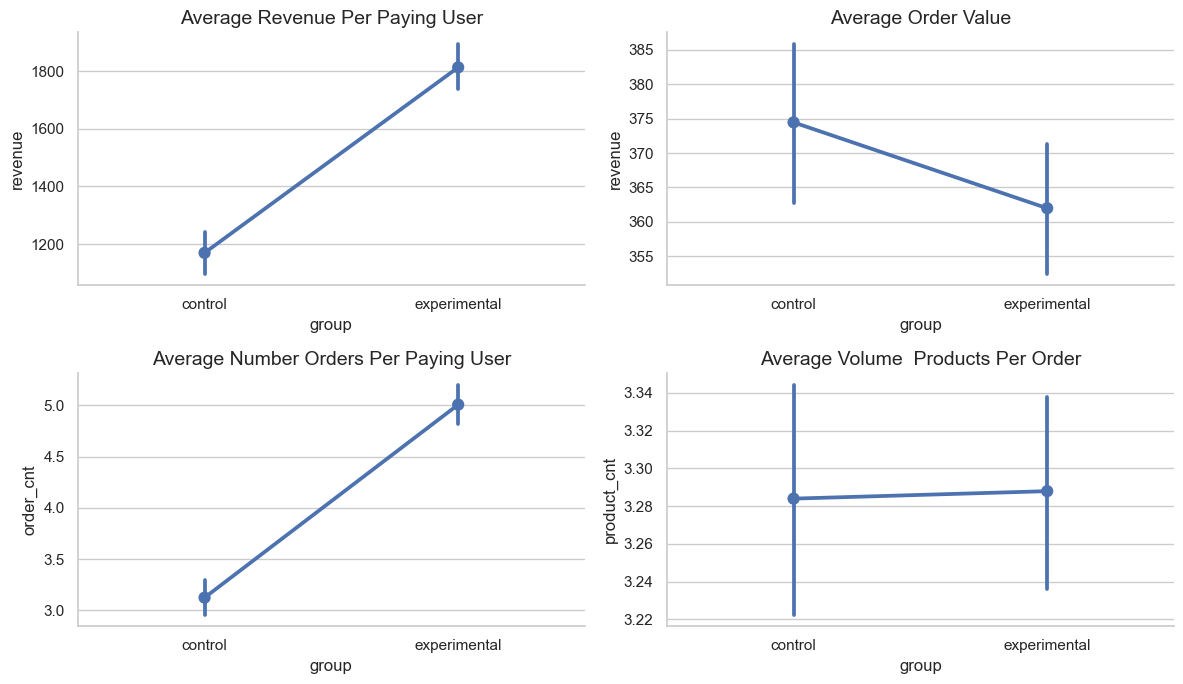

In [384]:
# Визуализируем средние по группам.
fig, axes = plt.subplots(nrows = 2, ncols = 2)
# ARPPU
sns.pointplot(x = 'group', y = 'revenue', data = arppu_opu, ax = axes[0,0])
axes[0,0].set_title('Average Revenue Per Paying User', fontsize = 14)
# AOV
sns.pointplot(x = 'group', y='revenue', data=aov_pm, ax = axes[0,1])
axes[0,1].set_title('Average Order Value', fontsize = 14)
# Среднее число заказов.
sns.pointplot(x = 'group', y = 'order_cnt', data = arppu_opu, ax = axes[1,0])
axes[1,0].set_title('Average Number Orders Per Paying User', fontsize = 14)
# Средний объем продуктовой корзины.
sns.pointplot(x = 'group', y='product_cnt', data=aov_pm, ax = axes[1,1])
axes[1,1].set_title('Average Volume  Products Per Order', fontsize = 14)

fig.tight_layout()
sns.despine()

Средние значения в экспериментальной группе для выручки и среднего числа заказов превышают значения в контрольной. Их доверительные интервалы не пересекаются. Это дает основание предполагать, что различия в данных метриках статистически значимы. <br>
Средние значения для размера продуктовой корзины и среднего чека имеют небольшие отклонения по группам, широкие доверительные интервалы, увеличивающие неопределенность и они явно пересекаются. Можно сделать предварительный вывод о том, что эти различия не имеют статистической значимости. Проверим данные baseline-утверждения при помощи стат. тестов.

Если объемы групп достаточно большие (число наблюдений в них > 30 ), и выборки совпадают по размерам, то можно не придерживаться требования нормальности распределения. Наши данные удовлетворяют выше описанным условиям, поэтому проверять данные на нормальность не будем.<br>
Для выбора статистического теста осталось проверить равенство дисперсий в группах (гомогенность). Для этого будем использовать критерий Левена. Если тест покажет, что дисперсии по группам не отличаются, то для оценки разницы в средних будем использовать t-критерий Стьюдента, если же наоборот дисперсии не равны, то - t-критерий Уэлча, который позволяет применять t-статистику и при этом учитывает разницу между двумя стандартными отклонениями.  

**Сформулируем нулевую и альтернативную гипотезы для проверки гомогенности дисперсии.**<br>
 - H0: дисперсии не отличаются по группам;
 - H1: дисперсии отличаются по группам.

In [350]:
# Проверка гомогенности дисперсии для ARPPU.
pg.homoscedasticity(data = arppu_opu, dv = 'revenue', group = 'group')

,W,pval,equal_var
levene,15.616459,0.000083,False


In [351]:
# Проверка гомогенности дисперсии для среднего числа заказов.
pg.homoscedasticity(data = arppu_opu, dv = 'order_cnt', group = 'group')

,W,pval,equal_var
levene,16.16773,0.000062,False


Для обоих тестов p-value < 0.05, тест отрицательный. Следовательно мы отклоняем нулевую гипотезу, т.е. условие гомогенности дисперсии не выполняется.<br>
А это значит, что для оценки значимости в разнице средних для ARPPU и среднего числа заказов, будем использовать t-критерий Уэлча.

In [352]:
# Проверка гомогенности дисперсии для AOV.
pg.homoscedasticity(data = aov_pm, dv = 'revenue', group = 'group')

,W,pval,equal_var
levene,0.616473,0.432406,True


In [353]:
# Проверка гомогенности дисперсии для среднего объема продуктовой карзины.
pg.homoscedasticity(data = aov_pm, dv = 'product_cnt', group = 'group') 

,W,pval,equal_var
levene,1.575829,0.209434,True


Для обоих тестов p-value > 0.05, тест положительный. Следовательно мы не можем отклонить нулевую гипотезу, т.е. условие гомогенности дисперсии выполняется.<br>
А это значит, что для оценки значимости в разнице средних для среднего чека и среднего числа заказов, будем использовать t-критерий Стьюдента.

**Сформулируем нулевую и альтернативную гипотезы для проверки значимости эффекта от внедрения рекомендательной системы.**<br>
 - H0: средние по группам не отличаются;
 - H1: средние по группам отличаются.

In [354]:
# ARPPU.
ss.ttest_ind(arppu_opu.query('group == "control"').revenue, arppu_opu.query('group == "experimental"').revenue, equal_var = False)

TtestResult(statistic=-11.714014287155067, pvalue=8.900523103269769e-30, df=992.4055301865121)

In [355]:
# Среднее число заказов.
ss.ttest_ind(arppu_opu.query('group == "control"').order_cnt, arppu_opu.query('group == "experimental"').order_cnt, equal_var = False)

TtestResult(statistic=-14.485156769858916, pvalue=2.9077831935473898e-43, df=988.4354749071716)

In [356]:
# AOV.
ss.ttest_ind(aov_pm.query('group == "control"').revenue, aov_pm.query('group == "experimental"').revenue)

TtestResult(statistic=1.6276451303367758, pvalue=0.10367659971189314, df=4121.0)

In [357]:
# Средний объем продуктовой карзины.
ss.ttest_ind(aov_pm.query('group == "control"').product_cnt, aov_pm.query('group == "experimental"').product_cnt)

TtestResult(statistic=-0.09831810423573854, pvalue=0.9216844843645677, df=4121.0)

Для ARPPU и среднего числа заказов p-value < 0.05, для AOV и среднего объема продуктовой корзины p-value > 0.05. Следовательно различия в средних для ARPPU и среднего числа заказов имеют статистическую значимость, а для AOV и среднего объема продуктовой корзины стат. значимость отсутствует.

**Аналитическое заключение.**<br>
Притом, что количество товаров в заказе пользователей не увеличилось, средний чек остался на том же уровне, пользователи стали делать заказы чаще. Результатом роста оборачиваемости товаров явилось увеличение выручки. Чем быстрее продаются товары, тем больше денег компания может получить за определенный период времени. Следовательно, внедрение умной системы рекомендаций товаров принесет пользу бизнесу. С другой стороны, ускорение оборачиваемости указывает и на увеличение спроса на товары. Т.е. рекомендательная система помогает пользователям эффективнее работать с приложением. Поэтому новую систему рекомендаций стоит включать на всех пользователей.